In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.colors import ListedColormap

colors = {
    'main': '#CFD923',
    'second': '#EB5D18',
    'extra': '#E0E0E0'
}

brunoyam_cmap = ListedColormap([colors['main'], colors['second'], colors['extra']])

plt.rcParams.update({'font.family':'Closer'})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

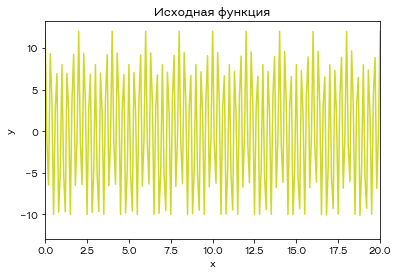

In [3]:
from scipy.fft import fft, ifft, fftfreq

n = 5000
t = 1 / 10
x = np.linspace(0, n * t, n)
y = 2 * np.cos(x * np.pi * 2 * 0.5) + 10 * np.cos(x * np.pi * 2 * 3)

plt.plot(x, y, color=colors['main'])
plt.xlim([0, 20])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Исходная функция')

plt.savefig('../images/func_to_fourier.jpg')

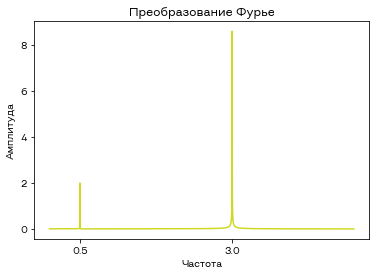

In [4]:
yf = fft(y)
xf = fftfreq(n, t)[:n//2]
plt.plot(xf, 2 / n * np.abs(yf[:n//2]), color=colors['main'])
plt.title('Преобразование Фурье')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.xticks([0.5, 3])

plt.savefig('../images/fourier.jpg')

# Видео 3
https://www.kaggle.com/datasets/shebrahimi/financial-distress

In [41]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dictionary_based import IndividualBOSS
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.dictionary_based import MUSE
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [14]:
def load_data(path, step=5):
    df = pd.read_csv(path)
    
    # Определяем таргет для задачи классификации по условию из описания датасета
    df['isDisstress'] = df['Financial Distress'].apply(lambda x: int(x < -0.5))
    # Делим датасет на x и y
    x = df.drop(['Financial Distress', 'isDisstress'], axis=1)
    x_values = x.iloc[:, 2:]
    x_values = (x_values - x_values.mean()) / x_values.std()
    x.iloc[:, 2:] = x_values

    # Таргет - находится ли компания в состоянии кризиса в последней точке
    y = df[['Company', 'Time', 'isDisstress']]
    y = y.groupby('Company')['isDisstress'].last()
    
    # Преобразуем датасет в формат sktime
    # По итогу должен получиться датафрейм, в котором в строках записаны компании, в колонках признаки, а в ячейках pd.Series
    # Причем все ряды должны быть одинаковой длины, будем брать только компании с 5 и более периодами, и будем брать последние 5 наблюдений
    df_ts = pd.DataFrame()
    real_y = {}
    for i, group in x.groupby('Company'):
        group = group.drop(['Company', 'Time'], axis=1)
        
        # Не рассматриваем компании с маленькой историей
        if len(group) < step:
            continue
        
        # Конвертируем в нужный формат
        case = {}
        for col in group.columns:
            cell = group[col][-step:].reset_index(drop=True)
            case[col] = [cell]
        
        # Добавляем новую компанию в датасет
        case = pd.DataFrame(case)
        df_ts = pd.concat([df_ts, case])

        # Не забываем формировать таргет только из нужных компаний
        real_y[i] = y.loc[i]
    df_ts.reset_index(drop=True, inplace=True)
    real_y = pd.Series(real_y)
    return df_ts, real_y

In [35]:
x, y = load_data('data/Financial Distress.csv', step=10)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
x_train.shape, x_test.shape

((145, 83), (63, 83))

In [46]:
concat_steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
concat_pipeline_tsf = Pipeline(concat_steps)

In [ ]:
column_ensemble = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)

In [ ]:
concat_steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", IndividualBOSS(window_size=5)),
]
concat_pipeline_boss = Pipeline(concat_steps)

In [51]:
models = [
    KNeighborsTimeSeriesClassifier(),
    concat_pipeline_tsf,
    column_ensemble,
    concat_pipeline_boss,
    MUSE(),
]
names = [
    'kNN',
    'concat pipeline tsf',
    'column ensemble',
    'concat pipeline boss',
    'MUSE'
]
result = {}
for model, name in zip(models, names):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    model_name = name
    error_number = len(y_test[pred != y_test])
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    conf_mat = confusion_matrix(y_test, pred)
    res_ = {
        'error_number': error_number,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_mat
    }
    result[model_name] = res_

In [52]:
pd.DataFrame(result)

,kNN,concat pipeline tsf,column ensemble,concat pipeline boss,MUSE
error_number,7,8,10,8,8
accuracy,0.888889,0.873016,0.84127,0.873016,0.873016
precision,0.75,1.0,0.0,0.666667,1.0
recall,0.333333,0.111111,0.0,0.222222,0.111111
f1,0.461538,0.2,0.0,0.333333,0.2
confusion_matrix,"[[53, 1], [6, 3]]","[[54, 0], [8, 1]]","[[53, 1], [9, 0]]","[[53, 1], [7, 2]]","[[54, 0], [8, 1]]"
